In [ ]:
pip install tensorflow

Note: you may need to restart the kernel to use updated packages.


You should consider upgrading via the 'C:\Users\shubham nimse\AppData\Local\Programs\Python\Python310\python.exe -m pip install --upgrade pip' command.


In [ ]:
# !pip install --upgrade tensorflow-gpu --user

In [ ]:
import tensorflow as tf
from tensorflow.keras import models,layers
import matplotlib.pyplot as plt

In [ ]:

#created variales for images size
IMAGE_SIZE=256
BATCH_SIZE=32
CHANNELS=3
EPOCHS=50

In [ ]:
dataset=tf.keras.preprocessing.image_dataset_from_directory("C:/Final project/rembg seg",
shuffle =True,
image_size=(IMAGE_SIZE,IMAGE_SIZE),
batch_size= BATCH_SIZE
)

Found 3082 files belonging to 7 classes.


In [ ]:
class_names=dataset.class_names
class_names

['Bacterial_Canker',
 'Healthy  leaf',
 'Healthy leaf',
 'Sooty Mould  Leaf',
 'Sooty Mould leaf',
 'anthracnose  leaf',
 'anthracnose leaf']

In [ ]:
len(dataset)

97

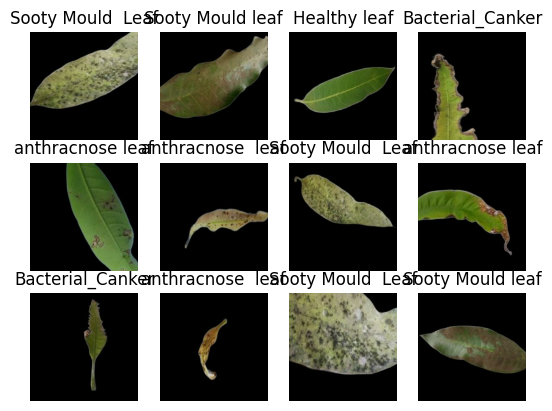

In [ ]:
for image_batch,label_batch in dataset.take(1):
    for i in range(12):
        ax=plt.subplot(3,4,i+1)
        plt.imshow(image_batch[i].numpy().astype("uint8"))
        plt.title(class_names[label_batch[i]])
        #to turn off the axis points
        plt.axis("off")
        
    

In [ ]:
#SPLITTING DATASET
#80 for training
# 20 for validation
#10 for tetsing
train_size=0.8
len(dataset)*train_size


77.60000000000001

In [ ]:
train_ds=dataset.take(54)
len(train_ds)

54

In [ ]:
test_ds=dataset.skip(54)
len(test_ds)

43

In [ ]:
val_size=0.1
len(dataset)*val_size

9.700000000000001

In [ ]:
val_ds=test_ds.take(6)
len(val_ds)

6

In [ ]:
test_ds=test_ds.skip(6)
len(test_ds)

37

In [ ]:
def get_dataset_partitions_tf(ds, train_split=0.8, val_split=0.1, test_split=0.1, shuffle=True, shuffle_size=10000):
    assert (train_split + test_split + val_split) == 1
    
    ds_size = len(ds)
    
    if shuffle:
        ds = ds.shuffle(shuffle_size, seed=12)
    
    train_size = int(train_split * ds_size)
    val_size = int(val_split * ds_size)
    
    train_ds = ds.take(train_size)    
    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size).skip(val_size)
    
    return train_ds, val_ds, test_ds


In [ ]:
train_ds, val_ds, test_ds = get_dataset_partitions_tf(dataset)

In [ ]:
len(train_ds)

77

In [ ]:
len(val_ds)

9

In [ ]:
len(test_ds)

11

In [ ]:
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

In [ ]:
resize_and_rescale = tf.keras.Sequential([
  layers.experimental.preprocessing.Resizing(IMAGE_SIZE, IMAGE_SIZE),
  layers.experimental.preprocessing.Rescaling(1./255),
])

In [ ]:
#Data Augmentation
#Data Augmentation is needed when we have less data, this boosts the accuracy of our model by augmenting the data.

data_augmentation = tf.keras.Sequential([
  layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
  layers.experimental.preprocessing.RandomRotation(0.2),
])

In [ ]:
#Applying Data Augmentation to Train Dataset
train_ds = train_ds.map(
    lambda x, y: (data_augmentation(x, training=True), y)
).prefetch(buffer_size=tf.data.AUTOTUNE)


In [ ]:
input_shape = (BATCH_SIZE, IMAGE_SIZE, IMAGE_SIZE, CHANNELS)
n_classes = 7

model = models.Sequential([
    resize_and_rescale,
    layers.Conv2D(32, kernel_size = (3,3), activation='relu', input_shape=input_shape),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(n_classes, activation='softmax'),
])


model.build(input_shape=input_shape)


In [ ]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (32, 256, 256, 3)         0         
                                                                 
 conv2d (Conv2D)             (32, 254, 254, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2D  (32, 127, 127, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (32, 125, 125, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (32, 62, 62, 64)         0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (32, 60, 60, 64)         

In [ ]:
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

In [ ]:
history = model.fit(
    train_ds,
    batch_size=BATCH_SIZE,
    validation_data=val_ds,
    verbose=1,
    epochs=25,
)

Epoch 1/25
77/77 [==============================] - 155s 2s/step - loss: 1.4943 - accuracy: 0.3747 - val_loss: 0.8837 - val_accuracy: 0.5868
Epoch 2/25
77/77 [==============================] - 187s 2s/step - loss: 0.8896 - accuracy: 0.6310 - val_loss: 0.8458 - val_accuracy: 0.6667
Epoch 3/25
77/77 [==============================] - 176s 2s/step - loss: 0.7457 - accuracy: 0.6982 - val_loss: 0.5491 - val_accuracy: 0.8125
Epoch 4/25
77/77 [==============================] - 128s 2s/step - loss: 0.5843 - accuracy: 0.7649 - val_loss: 0.4720 - val_accuracy: 0.8229
Epoch 5/25
77/77 [==============================] - 123s 2s/step - loss: 0.5279 - accuracy: 0.7854 - val_loss: 0.4371 - val_accuracy: 0.8194
Epoch 6/25
77/77 [==============================] - 124s 2s/step - loss: 0.4697 - accuracy: 0.8075 - val_loss: 0.3432 - val_accuracy: 0.8750
Epoch 7/25
77/77 [==============================] - 124s 2s/step - loss: 0.4041 - accuracy: 0.8243 - val_loss: 0.7003 - val_accuracy: 0.7535
Epoch 8/25
77

In [ ]:
scores = model.evaluate(test_ds)

11/11 [==============================] - 7s 344ms/step - loss: 0.2003 - accuracy: 0.9403


In [ ]:
scores

[0.20025792717933655, 0.9403409361839294]

In [ ]:
history.params

{'verbose': 1, 'epochs': 25, 'steps': 77}

In [ ]:
history.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

In [ ]:
type(history.history['loss'])

list

In [ ]:
len(history.history['loss'])

25

In [ ]:
history.history['loss'][:5] # show loss for first 5 epochs


[1.4943408966064453,
 0.8896141648292542,
 0.7457060813903809,
 0.5843378305435181,
 0.5279346108436584]

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

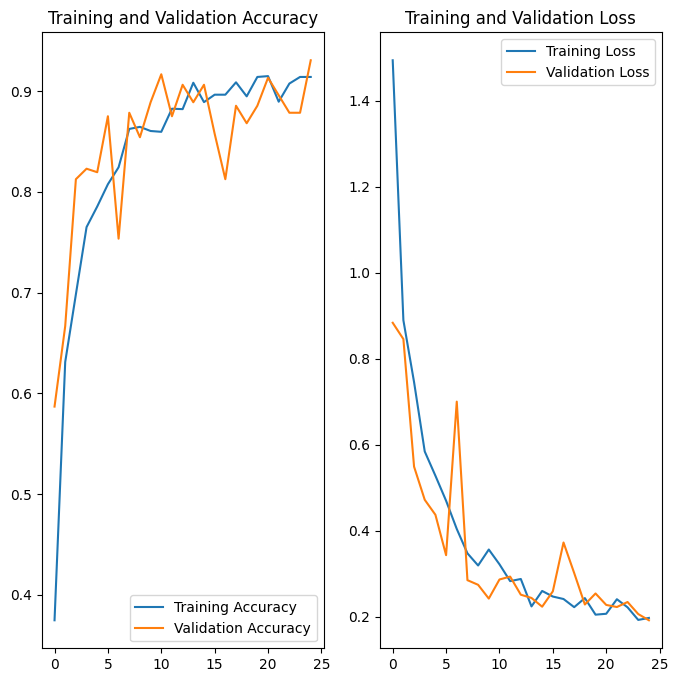

In [ ]:
plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(range(25), acc, label='Training Accuracy')
plt.plot(range(25), val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(range(25), loss, label='Training Loss')
plt.plot(range(25), val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

first image to predict
actual label: Healthy  leaf
1/1 [==============================] - 1s 541ms/step
predicted label: Healthy  leaf


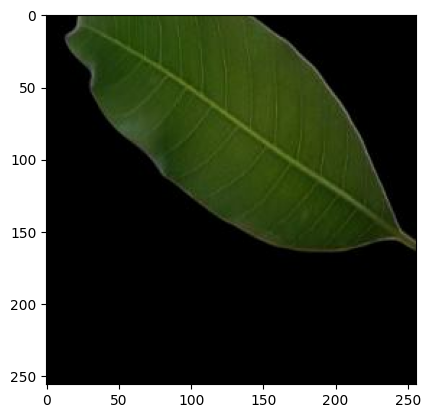

In [ ]:
import numpy as np
for images_batch, labels_batch in test_ds.take(1):
    
    first_image = images_batch[0].numpy().astype('uint8')
    first_label = labels_batch[0].numpy()
    
    print("first image to predict")
    plt.imshow(first_image)
    print("actual label:",class_names[first_label])
    
    batch_prediction = model.predict(images_batch)
    print("predicted label:",class_names[np.argmax(batch_prediction[0])])

In [ ]:
def predict(model, img):
    img_array = tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    img_array = tf.expand_dims(img_array, 0)

    predictions = model.predict(img_array)

    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = round(100 * (np.max(predictions[0])), 2)
    return predicted_class, confidence

1/1 [==============================] - 0s 31ms/step


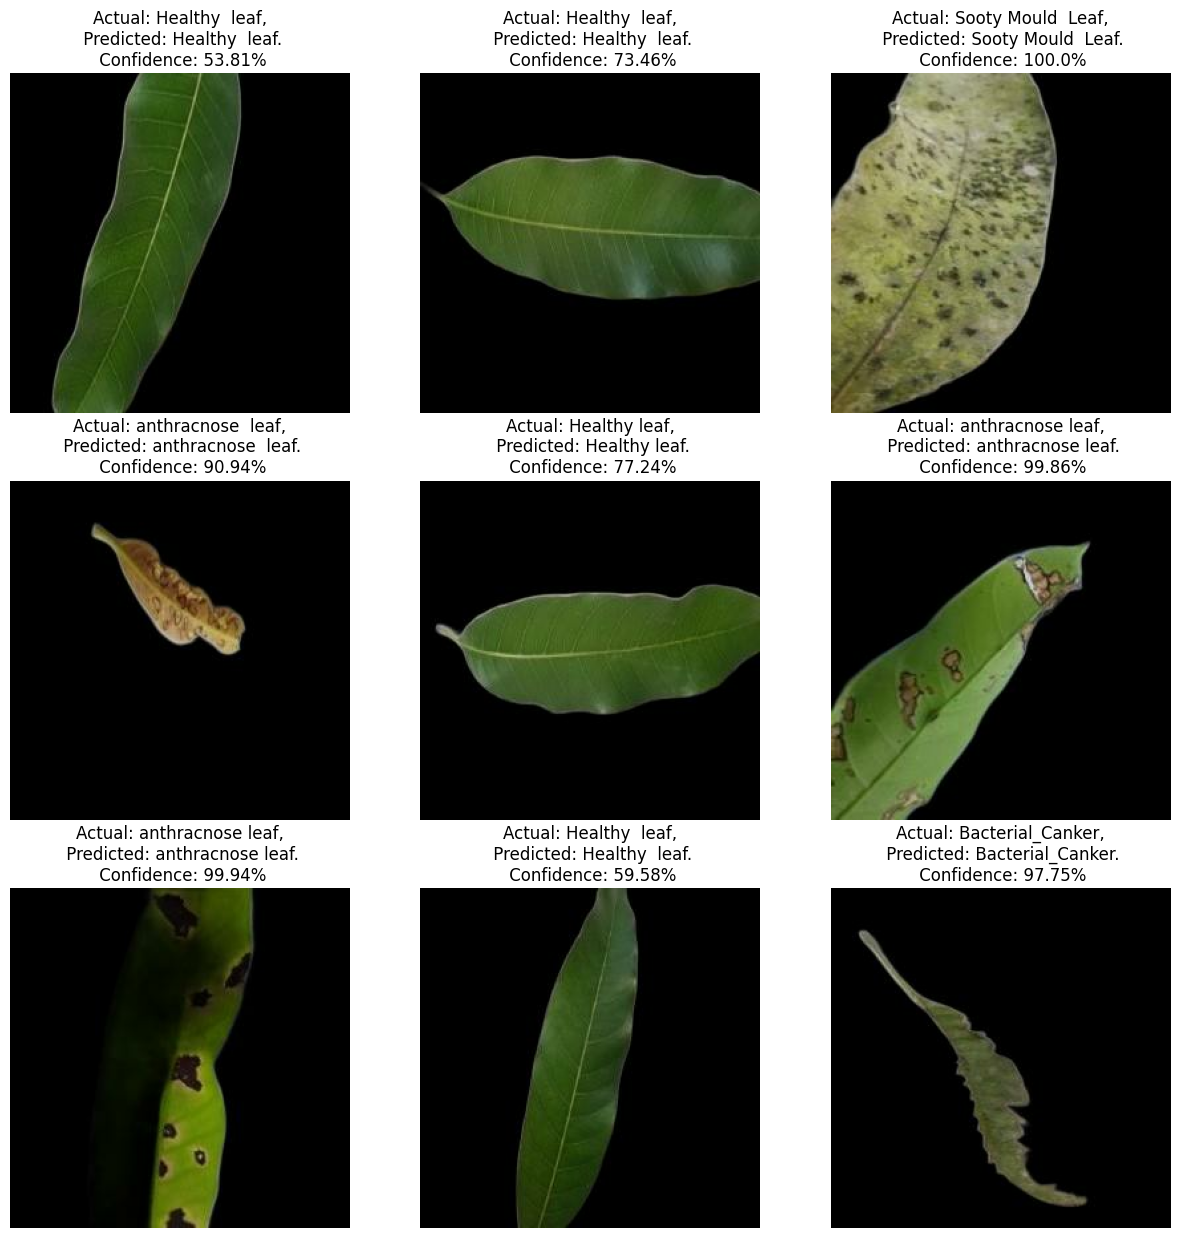

In [ ]:
plt.figure(figsize=(15, 15))
for images, labels in test_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        
        predicted_class, confidence = predict(model, images[i].numpy())
        actual_class = class_names[labels[i]] 
        
        plt.title(f"Actual: {actual_class},\n Predicted: {predicted_class}.\n Confidence: {confidence}%")
        
        plt.axis("off")

In [ ]:
model.save("C:/Final project/models/segmented.h5")


In [ ]:
import numpy as np
from keras.models import load_model

# Load the saved model
model = load_model("C:/Final project/models/segmented.h5")


first image to predict
actual label: Bacterial_Canker
1/1 [==============================] - 0s 388ms/step
predicted label: Bacterial_Canker


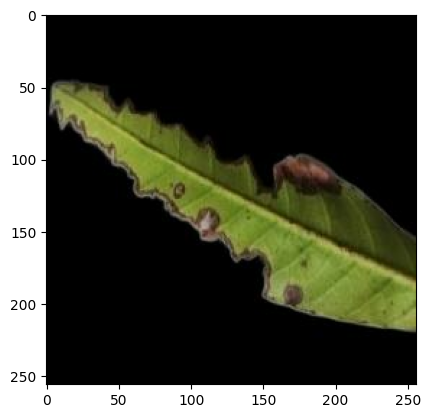

In [ ]:
import numpy as np
for images_batch, labels_batch in test_ds.take(1):
    
    first_image = images_batch[0].numpy().astype('uint8')
    first_label = labels_batch[0].numpy()
    
    print("first image to predict")
    plt.imshow(first_image)
    print("actual label:",class_names[first_label])
    
    batch_prediction = model.predict(images_batch)
    print("predicted label:",class_names[np.argmax(batch_prediction[0])])

In [ ]:
# import matplotlib.cm as cm

In [ ]:
# from IPython.display import Image,display

In [ ]:
# def save_and_display_gradcam(img_path,cam_path=):

In [ ]:
# def imag_prediction_and_visualization(past,last_conv_layer_name="conv2d_93",model=model):
#     img=img_to_array(path)
#     heatmap=make_gradcam_heatmap(img_array,model,last_conv_layer_name)
    
#     plt.title("the heatmap img")
#     plt.imshow(heatmap)
#     plt.show()
    
    
#     pred=np.argmax(model.predict(preprocess_input(img_array)))
#     print()
#     print()
#     print()
    
#     save_and_display_gradcam(path,heatmap)
    
#     print("original img")
    
#     a=plt.imread(path)
#     plt.imshow(a,cmap="gray")
#     plt.title("original image")
#     plt.show()